In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [49]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [50]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 200000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    #vgene_name = split[-1][1:-1]#.split("*")[0]
    vgene_name = split[-1][1:-1].split("*")[0]
    
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
"""    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)
"""

'    \nsource_sequence = np.array(source_sequence)\ntarget_sequence = np.array(target_sequence)\n\ncluster_tag = np.array(cluster_tag)\nvgene_tag = np.array(vgene_tag)\n\nprint(source_sequence.shape, target_sequence.shape)\nprint(max_source, max_target)\nprint()\nprint(cluster_tag.shape, vgene_tag.shape)\nprint(classes, vgenes)\n'

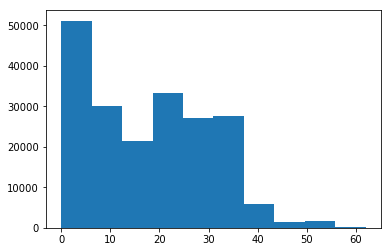

526 207 62
200000 200000


In [51]:
import matplotlib.pyplot as plt

plt.hist(vgene_tag)
plt.show()

print(max_source, max_target, max(vgene_tag))
print(len(source_sequence), len(target_sequence))

# Create Positive and Negative Dataset

In [5]:
for i in range(0, max_count):
    randomized = np.random.randint(0, 5, size=len(source_sequence[i]))
    source_sequence.append(randomized)
    target_sequence.append(target_sequence[i])
    

In [6]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

max_source_len = 526
max_target_len = int(max_source_len/2)

source_sequence = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
target_sequence = pad_sequences(target_sequence, maxlen=max_target_len, value=0)

print(source_sequence.shape, target_sequence.shape)


(400000, 526) (400000, 263)


In [7]:
shared_data_label = []
for i in range(len(source_sequence)):
    if i < int(len(source_sequence)/2):
        shared_data_label.append(1)
    else:
        shared_data_label.append(0)
shared_data_label = np.array(shared_data_label)
print(shared_data_label.shape, np.count_nonzero(shared_data_label))

(400000,) 200000


# Denoising Sequence

In [10]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import UpSampling1D
import numpy as np


input_source = Input(shape=(max_source_len,), dtype='int32', name='input_source')
input_target = Input(shape=(max_target_len,), dtype='int32', name='input_target')
#batch_shape=(batch_size, time_steps), 

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, \
                            name="embedding")
embed_source = embedding_layer(input_source)

#embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, \
#                            name="embedding")
embed_target = embedding_layer(input_target)

lstm_layer_source_one = LSTM(units=128, stateful=False, \
                            return_sequences=True, unroll=False, name="lstm_one_source")
lstm_one_source = lstm_layer_source_one(embed_source)

lstm_layer_target_one = LSTM(units=128, stateful=False, \
                            return_sequences=True, unroll=False, name="lstm_one_target")
lstm_one_target = lstm_layer_target_one(embed_target)


lstm_layer_source_two = LSTM(units=128, stateful=False, \
                            return_sequences=False, unroll=False, name="lstm_two_source")
lstm_two_source = lstm_layer_source_two(embed_source)#(lstm_one_source)

lstm_layer_target_two = LSTM(units=128, stateful=False, \
                            return_sequences=False, unroll=False, name="lstm_two_target")
lstm_two_target = lstm_layer_target_two(embed_source)#(lstm_one_target)


element_wise_product = keras.layers.Multiply()([lstm_two_source, lstm_two_target])
dot_product = keras.layers.Dot(axes=1, normalize=True)([lstm_two_source, lstm_two_target])

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid', name="logistic")(element_wise_product)

# We define a trainable model linking the
# tweet inputs to the predictions
shared_model = Model(inputs=[input_source, input_target], outputs=predictions)

shared_model.compile(optimizer="adam", #optimizer='sgd',
              loss="binary_crossentropy", #loss='mean_squared_error',
              metrics=['acc'])
shared_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_source (InputLayer)       (None, 526)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             24          input_source[0][0]               
__________________________________________________________________________________________________
lstm_two_source (LSTM)          (None, 128)          68096       embedding[0][0]                  
__________________________________________________________________________________________________
lstm_two_target (LSTM)          (None, 128)          68096       embedding[0][0]                  
__________________________________________________________________________________________________
multiply_2

In [11]:
from keras.utils import plot_model
plot_model(shared_model, to_file="model")

In [12]:
from keras_tqdm import TQDMNotebookCallback

print('Train...')
history = shared_model.fit([source_sequence, target_sequence], shared_data_label, 
        batch_size=batch_size*1, shuffle=True, epochs=1, verbose=2,
        callbacks=[TQDMNotebookCallback()])#, validation_data=(x_eval, y_eval))


Train...
Epoch 1/1
 - 2214s - loss: 0.3161 - acc: 0.8265



dict_keys(['loss', 'acc'])


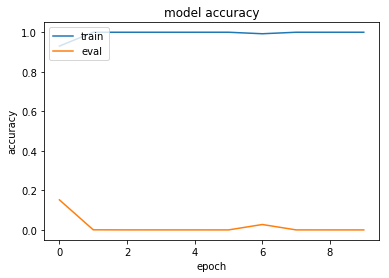

In [32]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Encoded Squence

In [52]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
max_count = 200000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source_len < len(source):
        max_source_len = len(source)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Gene /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
print(len(source_sequence), max_source_len)
print(len(vgene_tag), vgenes)


200000 526
200000 63


In [14]:
x_data = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
y_data = to_categorical(vgene_tag)
zeros = np.zeros((len(x_data), int(len(x_data[0])/2)))

print(x_data.shape, y_data.shape, zeros.shape)

(200000, 526) (200000, 63) (200000, 263)


In [15]:

layer_name = "lstm_two_source"
intermediate_layer_model = Model(inputs=shared_model.input,
                                 outputs=shared_model.get_layer(layer_name).get_output_at(0))
intermediate_output = intermediate_layer_model.predict([x_data, zeros])

print(intermediate_output.shape)

(200000, 128)


# Classifying Sequences

In [16]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

train_index = int((len(x_data) / batch_size) * 0.80 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = intermediate_output[0:train_index]
y_train = y_data[0:train_index]

x_eval = intermediate_output[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = intermediate_output[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (160000, 200000, 240000)
(160000, 128) (160000, 63)
(40000, 128) (40000, 63)
(0, 128) (0, 63)


In [20]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model


input_source = Input(shape=(max_source_len,), \
                     dtype='float32', name='main_input')

dense_layer_first = Dense(2048, activation='relu', \
                        name='fstlayer')(input_source)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(1024, activation='relu', \
                        name='midlayer1')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer_mid = Dense(512, activation='relu', \
                        name='midlayer2')(dense_layer_mid)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(256, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

classify_model = Model(inputs=[input_source], outputs=[dense_output])
classify_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

classify_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
fstlayer (Dense)             (None, 2048)              1079296   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
midlayer1 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
midlayer2 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________

In [ ]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = classify_model.fit(x_data, y_data, \
            #validation_data=(x_eval, y_eval), \
            epochs=200, shuffle=True, batch_size=1000, \
            callbacks=[TQDMNotebookCallback()], verbose=2)


Train...
Epoch 1/200
 - 25s - loss: 2.9384 - acc: 0.2206
Epoch 2/200
 - 24s - loss: 1.4070 - acc: 0.5492
Epoch 3/200
 - 24s - loss: 0.9796 - acc: 0.6727
Epoch 4/200
 - 25s - loss: 0.8287 - acc: 0.7232
Epoch 5/200
 - 24s - loss: 0.7331 - acc: 0.7544
Epoch 6/200
 - 24s - loss: 0.6833 - acc: 0.7720
Epoch 7/200
 - 24s - loss: 0.6481 - acc: 0.7845
Epoch 8/200
 - 26s - loss: 0.6204 - acc: 0.7941
Epoch 9/200
 - 27s - loss: 0.6063 - acc: 0.7988
Epoch 10/200
 - 25s - loss: 0.5914 - acc: 0.8032
Epoch 11/200
 - 25s - loss: 0.5708 - acc: 0.8098
Epoch 12/200
 - 25s - loss: 0.5578 - acc: 0.8143
Epoch 13/200
 - 28s - loss: 0.5424 - acc: 0.8201
Epoch 14/200
 - 26s - loss: 0.5375 - acc: 0.8225
Epoch 15/200
 - 25s - loss: 0.5300 - acc: 0.8232
Epoch 16/200
 - 25s - loss: 0.5290 - acc: 0.8246
Epoch 17/200
 - 25s - loss: 0.5116 - acc: 0.8308
Epoch 18/200
 - 26s - loss: 0.5055 - acc: 0.8331
Epoch 19/200
 - 25s - loss: 0.5002 - acc: 0.8339
Epoch 20/200
 - 24s - loss: 0.4837 - acc: 0.8392
Epoch 21/200
 - 26s 

# 200 Epochs

dict_keys(['loss', 'acc'])


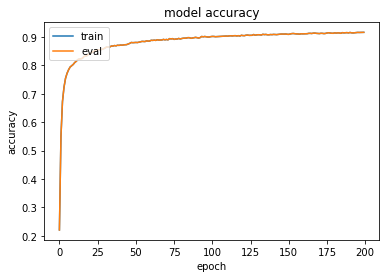

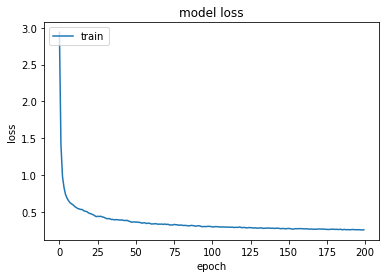

In [23]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Apply Attention

In [70]:
file_read = open("../imgtvgene_sequence_classification/naive.txt")

source_sequence = []
target_sequence = []

max_count = 200000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    try:
        source = [char_to_int[x] for x in split[2][1:-1]]
        if max_source_len < len(source):
            max_source_len = len(source)

        target = [char_to_int[x] for x in split[3][1:-1] if x in "NACGT"]
        
        assert(len(target) < len(source))
    except:
        continue
        
    source_sequence.append(source)
    target_sequence.append(target)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Gene /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
print(len(source_sequence), max_source_len)
print(len(vgene_tag), vgenes)


200000 507
200000 56


In [71]:
np.array(source)

array([2, 1, 3, 3, 4, 3, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 3, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 4, 4, 4, 3, 2,
       1, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 4, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 3, 3, 4, 4, 4, 2, 4, 1, 2, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 1, 3, 4, 1,
       4, 2, 4, 2, 4, 2, 1, 4, 1, 3, 4, 3, 3, 3, 1, 2, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 3, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 3, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 1, 2, 4, 2, 4, 3, 4, 3, 3, 2, 2, 3, 2, 2,
       3, 2, 1, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 2,

In [72]:
np.array(target)

array([2, 1, 3, 3, 4, 3, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 3, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 2, 2, 4, 3, 2,
       1, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 2, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 3, 3, 4, 4, 1, 2, 4, 1, 2, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 1, 3, 4, 1,
       4, 2, 4, 1, 4, 2, 1, 4, 1, 3, 4, 3, 3, 3, 1, 3, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 1, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 3, 2, 4, 2, 4, 3, 4, 3, 1, 2, 2, 3, 2, 2,
       3, 2, 1, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 3, 1])

In [73]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

source_data = pad_sequences(source_sequence, maxlen=max_source_len, padding='post', value=0)
classes = to_categorical(vgene_tag)
target_data = pad_sequences(target_sequence, maxlen=max_source_len, padding='post', value=0)

print(len(source_sequence), len(vgene_tag), len(target_sequence))
print(source_data.shape, classes.shape, target_data.shape)

200000 200000 200000
(200000, 507) (200000, 56) (200000, 507)


In [74]:
source_data[0]

array([2, 1, 3, 3, 4, 1, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 2, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 2, 2, 4, 3, 2,
       3, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 2, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 1, 3, 4, 1, 1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 1, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 4, 1, 2, 1,
       4, 2, 4, 1, 4, 4, 1, 4, 1, 3, 4, 3, 3, 3, 1, 3, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 3, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 3, 2, 4, 2, 4, 3, 4, 3, 1, 2, 2, 3, 2, 2,
       3, 4, 3, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 1, 1, 1, 3, 3, 4, 1,

In [75]:
target_data[0]

array([2, 1, 3, 3, 4, 1, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 2, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 2, 2, 4, 3, 2,
       3, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 2, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 1, 3, 4, 1, 1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 1, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 4, 1, 2, 1,
       4, 2, 4, 1, 4, 4, 1, 4, 1, 3, 4, 3, 3, 3, 1, 3, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 3, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 3, 2, 4, 2, 4, 3, 4, 3, 1, 2, 2, 3, 2, 2,
       3, 4, 3, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 1, 1, 0, 0, 0, 0, 0,

In [76]:
def one_hot_encode(sequence, n_unique):
    encoding = np.zeros((len(sequence), n_unique))
    
    for i in range(len(sequence)):
        encoding[i][sequence[i]] = 1
    
    return encoding

print(max(source_data[0]), max(target_data[0]))
print(one_hot_encode(source_data[0], vocab_size))
print(one_hot_encode(target_data[0], vocab_size))

4 4
[[0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [77]:
source_encoded = np.array([one_hot_encode(seq, vocab_size-1) for seq in source_data[:]])
print(source_encoded.shape)
    

(200000, 507, 5)


In [78]:
source_encoded[0]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [79]:
target_encoded = np.array([one_hot_encode(seq, vocab_size-1) for seq in target_data[:]])
print(target_encoded.shape)
    

(200000, 507, 5)


In [80]:
target_encoded[0]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [81]:
# define the encoder-decoder model
def baseline_model(n_timesteps_in, n_features):
    model = Sequential()
    model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
    model.add(RepeatVector(n_timesteps_in))
    model.add(LSTM(150, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    return model


In [88]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from custom_recurrents import AttentionDecoder
from keras_tqdm import TQDMNotebookCallback

print('Train...')

train_data_size = 10000
test_source_len = max_source_len
model = baseline_model(test_source_len, vocab_size-1)

model.fit(source_encoded[:train_data_size, :test_source_len, :], \
          target_encoded[:train_data_size, :test_source_len, :], epochs=10,
          callbacks=[TQDMNotebookCallback()], verbose=2)

Train...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 150)               93600     
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 507, 150)          0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 507, 150)          180600    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 507, 5)            755       
Total params: 274,955
Trainable params: 274,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 295s - loss: 1.4697 - acc: 0.4280
Epoch 2/10
 - 289s - loss: 1.4664 - acc: 0.4314
Epoch 3/10
 - 289s - loss: 1.4605 - acc: 0.4344
Epoch 4/10
 - 288s - loss: 1.4715 - acc: 0.4281
Epoch 5/10
 - 289s - loss: 1.4668 - acc: 0.4307
Epoch 6/10
 - 289s 

In [85]:
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps_in, n_features), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(AttentionDecoder(128, n_features))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    return model


In [87]:
print('Train...')

train_data_size = 10000
test_source_len = max_source_len #100
model = attention_model(test_source_len, vocab_size-1)

model.fit(source_encoded[:train_data_size, :test_source_len, :], \
          target_encoded[:train_data_size, :test_source_len, :], epochs=10,
          callbacks=[TQDMNotebookCallback()], verbose=2)

Train...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 507, 128)          68608     
_________________________________________________________________
lstm_49 (LSTM)               (None, 507, 128)          131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 507, 5)            151326    
Total params: 351,518
Trainable params: 351,518
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 7108s - loss: 1.0921 - acc: 0.5329
Epoch 2/10
 - 8691s - loss: 0.8611 - acc: 0.5935
Epoch 3/10
 - 4276s - loss: 0.8217 - acc: 0.6074
Epoch 4/10
 - 4267s - loss: 0.7832 - acc: 0.6216
Epoch 5/10
 - 4283s - loss: 0.7716 - acc: 0.6307
Epoch 6/10
 - 4261s - loss: 0.7997 - acc: 0.6237
Epoch 7/10
 - 4294s - loss: 0.7596 - acc: 0.6327
Epoch 8/10
 - 4200s - loss: 0.7529 - acc: 0.6346

In [55]:
source_encoded[:train_data_size, :test_source_len, :]

array([[[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0

In [56]:
target_encoded[:train_data_size, :test_source_len, :]

array([[[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0